## Lab 4.1: Dataset Challenge

By: Rachel Hartfelder

In [21]:
%%capture
%pip install numpy
!pip install torch
%pip install pandas
%pip install matplotlib

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader

## Load and Preprocess Titanic Dataset

In [23]:
full_dataset = pd.read_csv('./titanic/train.csv')

# Preprocess the data
y = full_dataset['Survived']
X_unprocessed = full_dataset[['Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Fare', 'Embarked']].copy()

# Fill missing values
X_unprocessed['Fare'] = X_unprocessed['Fare'].fillna(X_unprocessed['Fare'].median())
X_unprocessed['Age'] = X_unprocessed['Age'].fillna(X_unprocessed['Age'].median())
X_unprocessed['Embarked'] = X_unprocessed['Embarked'].fillna(X_unprocessed['Embarked'].mode()[0])

# Standardize numerical columns
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']
X_unprocessed[num_cols] = (X_unprocessed[num_cols] - X_unprocessed[num_cols].mean()) / X_unprocessed[num_cols].std()

# One-hot encode categorical columns
X = pd.get_dummies(X_unprocessed).astype(float)

X = torch.tensor(X.values).float()
y = torch.tensor(y).long()


### Split Data into Train-Test Set

In [24]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size 


seed = torch.Generator().manual_seed(49)
train_dataset, test_dataset= random_split(torch.utils.data.TensorDataset(X,y), [train_size, test_size], generator=seed)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = X.shape[1]
y_train_t = y[train_dataset.indices]
num_classes = len(torch.unique(y_train_t))


### Function to Calculate Accuracy

In [25]:
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    for X, y in loader:
        outputs = model(X)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total

### Function to Train the Model

In [26]:
def train_model(model, train_loader, test_loader, opt, epochs=100):
    loss_fn = torch.nn.CrossEntropyLoss()
    lr = 1e-2
    
    train_acc_array = []

    test_acc_array = []

    #opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.001)

    for epoch in range(epochs):
        model.train()

        for X_train, y_train in train_loader:
            opt.zero_grad()
            z = model(X_train) 
            loss = loss_fn(z,y_train) 
            loss.backward() 
            opt.step() 

        train_acc = accuracy(model, train_loader)

        train_acc_array.append(train_acc)

        test_acc = accuracy(model, test_loader)

        test_acc_array.append(test_acc)

        print(f"Epoch: {epoch+1}")
        print(f"Loss: {loss.item():.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}\n")

    plt.xlabel("Epoch")

    plt.ylabel("Accuracy")
    
    plt.plot(range(1, 101), train_acc_array)

    plt.plot(range(1, 101), test_acc_array)
       

### Linear Model

Epoch: 1
Loss: 0.5742 | Train Accuracy: 0.6208 | Test Accuracy: 0.6369

Epoch: 2
Loss: 0.6730 | Train Accuracy: 0.6517 | Test Accuracy: 0.6425

Epoch: 3
Loss: 0.4779 | Train Accuracy: 0.6784 | Test Accuracy: 0.6480

Epoch: 4
Loss: 0.7244 | Train Accuracy: 0.6812 | Test Accuracy: 0.6592

Epoch: 5
Loss: 0.5183 | Train Accuracy: 0.6826 | Test Accuracy: 0.6592

Epoch: 6
Loss: 0.7734 | Train Accuracy: 0.6854 | Test Accuracy: 0.6592

Epoch: 7
Loss: 0.7110 | Train Accuracy: 0.6868 | Test Accuracy: 0.6648

Epoch: 8
Loss: 0.7287 | Train Accuracy: 0.6924 | Test Accuracy: 0.6648

Epoch: 9
Loss: 0.5204 | Train Accuracy: 0.7008 | Test Accuracy: 0.6927

Epoch: 10
Loss: 0.4483 | Train Accuracy: 0.7022 | Test Accuracy: 0.6927

Epoch: 11
Loss: 0.5993 | Train Accuracy: 0.7107 | Test Accuracy: 0.7039

Epoch: 12
Loss: 0.5540 | Train Accuracy: 0.7093 | Test Accuracy: 0.7095

Epoch: 13
Loss: 0.4675 | Train Accuracy: 0.7107 | Test Accuracy: 0.7151

Epoch: 14
Loss: 0.7189 | Train Accuracy: 0.7163 | Test Accur

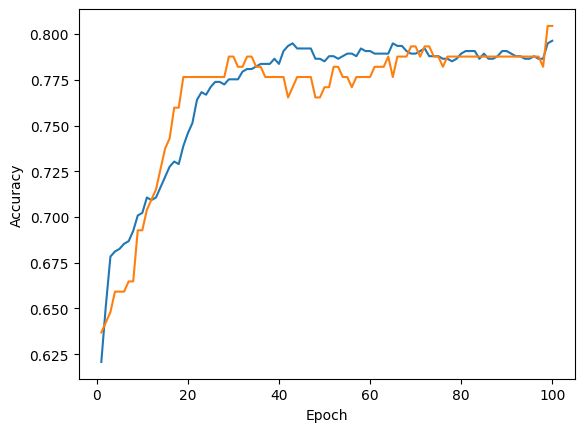

In [27]:
linear_model = torch.nn.Linear(input_dim, num_classes)

sdg_opt = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

train_model(linear_model, train_loader, test_loader, sdg_opt)

## Define a Model

We chose to define a simple Neural Network with three layers and one hidden layer of size 100.

In [28]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

### No Optimization

Epoch: 1
Loss: 0.6930 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 2
Loss: 0.6502 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 3
Loss: 0.6877 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.6604 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.7266 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.6630 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.6010 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.5946 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.7049 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.7483 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.6245 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.5389 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.5883 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.6184 | Train Accuracy: 0.6138 | Test Accur

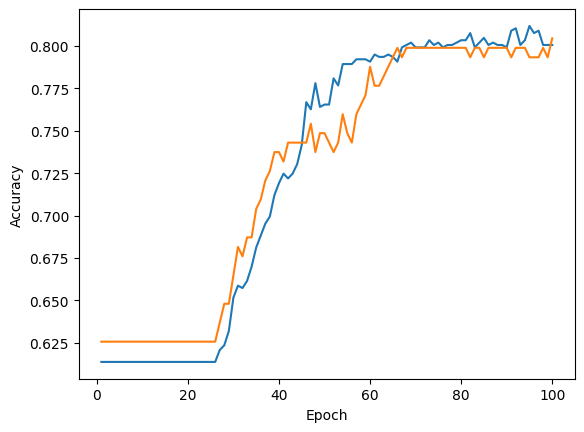

In [29]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2)

train_model(nn_model, train_loader, test_loader, sdg_opt)

### Regularization

#### Weight Decay = 0.001

Epoch: 1
Loss: 0.7078 | Train Accuracy: 0.4031 | Test Accuracy: 0.4022

Epoch: 2
Loss: 0.6904 | Train Accuracy: 0.6011 | Test Accuracy: 0.5978

Epoch: 3
Loss: 0.6878 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.6751 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.6658 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.6974 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.6681 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.6445 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.6447 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.5772 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.6939 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.5793 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.6754 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.7618 | Train Accuracy: 0.6138 | Test Accur

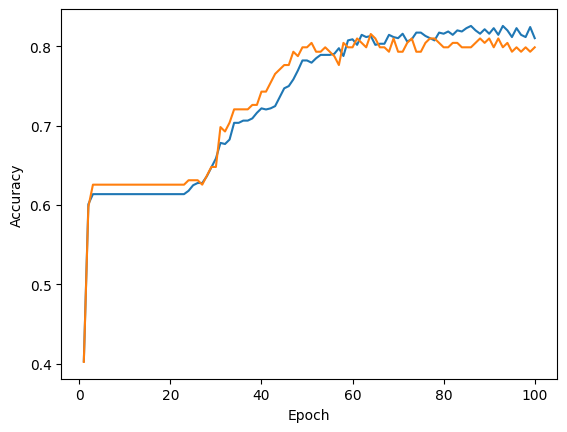

In [30]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.001)

train_model(nn_model, train_loader, test_loader, sdg_opt)

#### Weight Decay = 0.01

Epoch: 1
Loss: 0.6715 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 2
Loss: 0.6377 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 3
Loss: 0.6137 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.7679 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.6405 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.6500 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.6564 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.5899 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.6096 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.6402 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.7269 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.5114 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.5917 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.6104 | Train Accuracy: 0.6138 | Test Accur

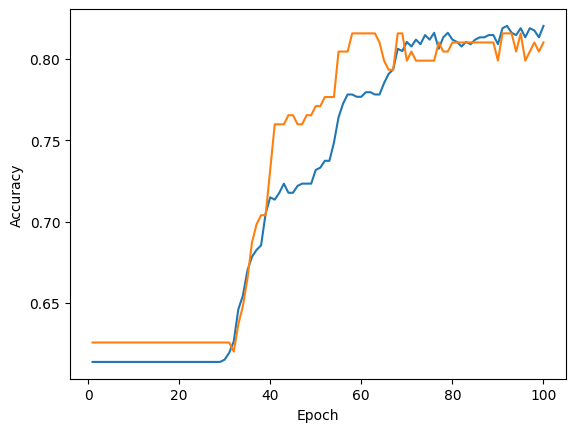

In [31]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.01)

train_model(nn_model, train_loader, test_loader, sdg_opt)

#### Weight Decay = 0.1

Epoch: 1
Loss: 0.6950 | Train Accuracy: 0.3862 | Test Accuracy: 0.3743

Epoch: 2
Loss: 0.6859 | Train Accuracy: 0.4003 | Test Accuracy: 0.3911

Epoch: 3
Loss: 0.6766 | Train Accuracy: 0.7570 | Test Accuracy: 0.7709

Epoch: 4
Loss: 0.6912 | Train Accuracy: 0.6573 | Test Accuracy: 0.6592

Epoch: 5
Loss: 0.6664 | Train Accuracy: 0.6194 | Test Accuracy: 0.6313

Epoch: 6
Loss: 0.6866 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.6569 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.7227 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.6854 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.6953 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.6826 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.6441 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.6363 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.7620 | Train Accuracy: 0.6138 | Test Accur

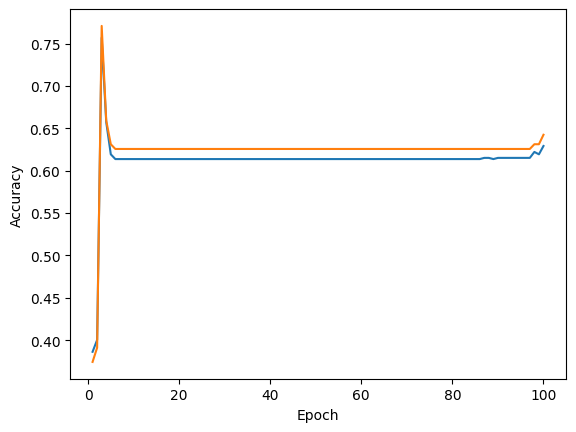

In [32]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.1)

train_model(nn_model, train_loader, test_loader, sdg_opt)

#### Weight Decay = 1

Epoch: 1
Loss: 0.6816 | Train Accuracy: 0.7219 | Test Accuracy: 0.7430

Epoch: 2
Loss: 0.6842 | Train Accuracy: 0.6152 | Test Accuracy: 0.6145

Epoch: 3
Loss: 0.6962 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.6861 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.6926 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.7046 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.6816 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.6533 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.6647 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.6627 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.7296 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.6786 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.7300 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.6786 | Train Accuracy: 0.6138 | Test Accur

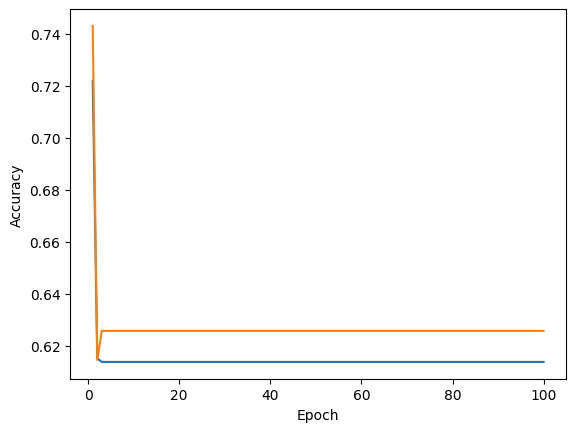

In [33]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1)

train_model(nn_model, train_loader, test_loader, sdg_opt)

The model without weight decay performed well and did not overfit to the data. Adding regularization to the model is therefore not necessary. Adding small amounts of weight decay did not seem to affect the model while large values of weight decay worsened the model since it was forcing the weights to be unnecessarily small.

## Optimizers

### Adam Optimizer

Epoch: 1
Loss: 0.3553 | Train Accuracy: 0.8076 | Test Accuracy: 0.8212

Epoch: 2
Loss: 0.3617 | Train Accuracy: 0.8272 | Test Accuracy: 0.8156

Epoch: 3
Loss: 0.3513 | Train Accuracy: 0.8343 | Test Accuracy: 0.8156

Epoch: 4
Loss: 0.2267 | Train Accuracy: 0.8399 | Test Accuracy: 0.8101

Epoch: 5
Loss: 0.3050 | Train Accuracy: 0.8413 | Test Accuracy: 0.7765

Epoch: 6
Loss: 0.1969 | Train Accuracy: 0.8048 | Test Accuracy: 0.7821

Epoch: 7
Loss: 0.3199 | Train Accuracy: 0.8357 | Test Accuracy: 0.7989

Epoch: 8
Loss: 0.6977 | Train Accuracy: 0.8497 | Test Accuracy: 0.7989

Epoch: 9
Loss: 0.4399 | Train Accuracy: 0.8511 | Test Accuracy: 0.8101

Epoch: 10
Loss: 0.6077 | Train Accuracy: 0.8469 | Test Accuracy: 0.8268

Epoch: 11
Loss: 0.3723 | Train Accuracy: 0.8483 | Test Accuracy: 0.8045

Epoch: 12
Loss: 0.3847 | Train Accuracy: 0.8539 | Test Accuracy: 0.8045

Epoch: 13
Loss: 0.5543 | Train Accuracy: 0.8483 | Test Accuracy: 0.7989

Epoch: 14
Loss: 0.3490 | Train Accuracy: 0.8596 | Test Accur

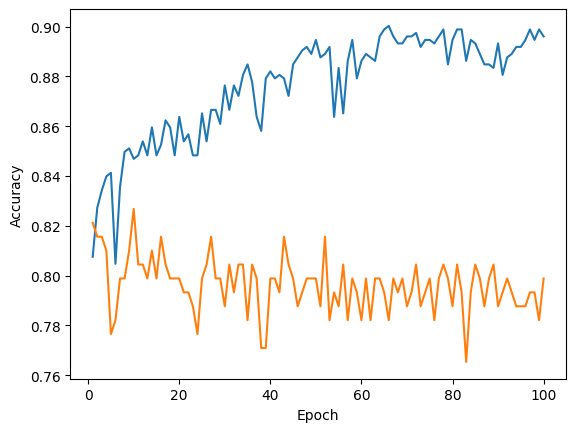

In [34]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

adam_opt = torch.optim.Adam(nn_model.parameters(), lr=1e-2)

train_model(nn_model, train_loader, test_loader, adam_opt)

### Adam Optmizer with Weight Decay = 0.001

Epoch: 1
Loss: 0.4403 | Train Accuracy: 0.8090 | Test Accuracy: 0.8045

Epoch: 2
Loss: 0.4065 | Train Accuracy: 0.8315 | Test Accuracy: 0.8045

Epoch: 3
Loss: 0.9854 | Train Accuracy: 0.8272 | Test Accuracy: 0.8156

Epoch: 4
Loss: 0.5942 | Train Accuracy: 0.8441 | Test Accuracy: 0.8045

Epoch: 5
Loss: 0.3290 | Train Accuracy: 0.8511 | Test Accuracy: 0.8212

Epoch: 6
Loss: 0.2818 | Train Accuracy: 0.8272 | Test Accuracy: 0.8156

Epoch: 7
Loss: 0.8070 | Train Accuracy: 0.8455 | Test Accuracy: 0.7933

Epoch: 8
Loss: 0.2576 | Train Accuracy: 0.8497 | Test Accuracy: 0.7877

Epoch: 9
Loss: 0.8100 | Train Accuracy: 0.8483 | Test Accuracy: 0.8045

Epoch: 10
Loss: 0.4412 | Train Accuracy: 0.8567 | Test Accuracy: 0.8045

Epoch: 11
Loss: 0.6184 | Train Accuracy: 0.8497 | Test Accuracy: 0.7821

Epoch: 12
Loss: 0.6169 | Train Accuracy: 0.8469 | Test Accuracy: 0.8045

Epoch: 13
Loss: 0.5351 | Train Accuracy: 0.8567 | Test Accuracy: 0.7933

Epoch: 14
Loss: 0.2884 | Train Accuracy: 0.8385 | Test Accur

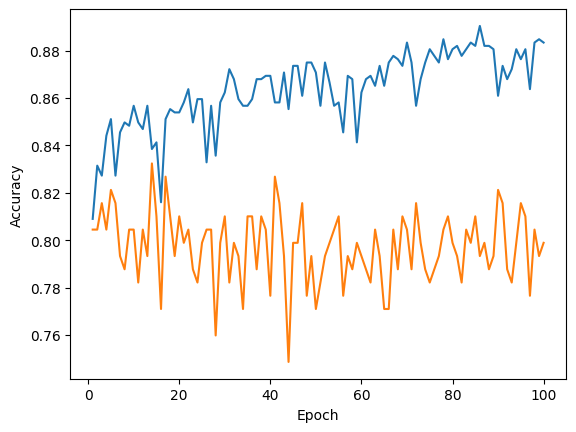

In [41]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

adam_opt = torch.optim.Adam(nn_model.parameters(), lr=1e-2, weight_decay = 0.001)

train_model(nn_model, train_loader, test_loader, adam_opt)

The model using the Adam Optimizer performed well but did not show significant improvements compared to the stochastic gradient descent optmizer.

## Batch Normalization

### Batch Normalization with No Optimization

Epoch: 1
Loss: 0.5750 | Train Accuracy: 0.6503 | Test Accuracy: 0.6648

Epoch: 2
Loss: 0.8190 | Train Accuracy: 0.7654 | Test Accuracy: 0.7654

Epoch: 3
Loss: 0.5276 | Train Accuracy: 0.8230 | Test Accuracy: 0.7989

Epoch: 4
Loss: 0.4006 | Train Accuracy: 0.8244 | Test Accuracy: 0.8156

Epoch: 5
Loss: 0.8151 | Train Accuracy: 0.8272 | Test Accuracy: 0.8101

Epoch: 6
Loss: 0.3244 | Train Accuracy: 0.8287 | Test Accuracy: 0.8101

Epoch: 7
Loss: 0.7027 | Train Accuracy: 0.8357 | Test Accuracy: 0.8045

Epoch: 8
Loss: 0.9307 | Train Accuracy: 0.8371 | Test Accuracy: 0.8101

Epoch: 9
Loss: 0.3790 | Train Accuracy: 0.8399 | Test Accuracy: 0.8101

Epoch: 10
Loss: 0.4523 | Train Accuracy: 0.8371 | Test Accuracy: 0.8268

Epoch: 11
Loss: 0.4087 | Train Accuracy: 0.8385 | Test Accuracy: 0.8101

Epoch: 12
Loss: 0.2741 | Train Accuracy: 0.8399 | Test Accuracy: 0.7989

Epoch: 13
Loss: 0.4011 | Train Accuracy: 0.8413 | Test Accuracy: 0.8045

Epoch: 14
Loss: 0.2789 | Train Accuracy: 0.8497 | Test Accur

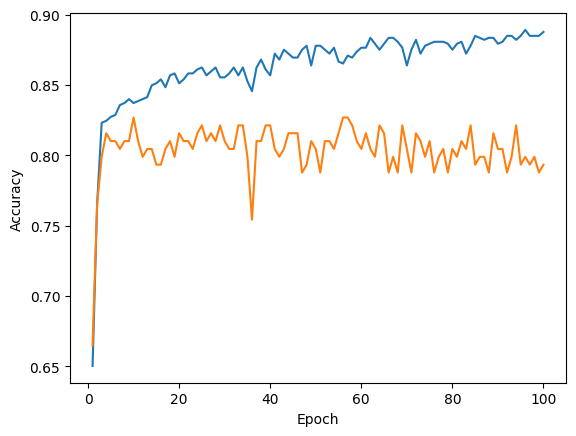

In [35]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2)

train_model(nn_model, train_loader, test_loader, sdg_opt)

### Batch normalization with Regularization


#### Weight Decay = 0.001

Epoch: 1
Loss: 0.6146 | Train Accuracy: 0.6447 | Test Accuracy: 0.6536

Epoch: 2
Loss: 0.6772 | Train Accuracy: 0.7584 | Test Accuracy: 0.7765

Epoch: 3
Loss: 0.8759 | Train Accuracy: 0.8090 | Test Accuracy: 0.7877

Epoch: 4
Loss: 0.7179 | Train Accuracy: 0.8343 | Test Accuracy: 0.7989

Epoch: 5
Loss: 0.4355 | Train Accuracy: 0.8385 | Test Accuracy: 0.8101

Epoch: 6
Loss: 0.5735 | Train Accuracy: 0.8371 | Test Accuracy: 0.8156

Epoch: 7
Loss: 0.4333 | Train Accuracy: 0.8315 | Test Accuracy: 0.8268

Epoch: 8
Loss: 0.4547 | Train Accuracy: 0.8441 | Test Accuracy: 0.8156

Epoch: 9
Loss: 0.3191 | Train Accuracy: 0.8497 | Test Accuracy: 0.8045

Epoch: 10
Loss: 0.5616 | Train Accuracy: 0.8357 | Test Accuracy: 0.8101

Epoch: 11
Loss: 0.3389 | Train Accuracy: 0.8427 | Test Accuracy: 0.8212

Epoch: 12
Loss: 0.6913 | Train Accuracy: 0.8399 | Test Accuracy: 0.8156

Epoch: 13
Loss: 0.3015 | Train Accuracy: 0.8455 | Test Accuracy: 0.8101

Epoch: 14
Loss: 0.1743 | Train Accuracy: 0.8483 | Test Accur

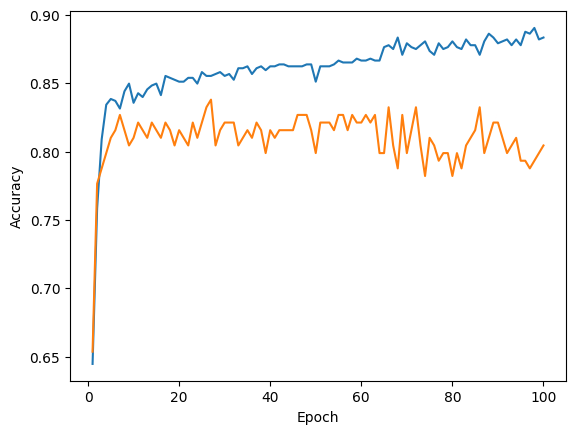

In [36]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.001)

train_model(nn_model, train_loader, test_loader, sdg_opt)

#### Weight Decay = 0.01

Epoch: 1
Loss: 0.5997 | Train Accuracy: 0.6573 | Test Accuracy: 0.6425

Epoch: 2
Loss: 0.6014 | Train Accuracy: 0.7823 | Test Accuracy: 0.7933

Epoch: 3
Loss: 0.4498 | Train Accuracy: 0.8272 | Test Accuracy: 0.8045

Epoch: 4
Loss: 0.3508 | Train Accuracy: 0.8301 | Test Accuracy: 0.7989

Epoch: 5
Loss: 0.3316 | Train Accuracy: 0.8357 | Test Accuracy: 0.8045

Epoch: 6
Loss: 0.4526 | Train Accuracy: 0.8287 | Test Accuracy: 0.8045

Epoch: 7
Loss: 0.5006 | Train Accuracy: 0.8385 | Test Accuracy: 0.7989

Epoch: 8
Loss: 0.7151 | Train Accuracy: 0.8413 | Test Accuracy: 0.8156

Epoch: 9
Loss: 0.3709 | Train Accuracy: 0.8441 | Test Accuracy: 0.8101

Epoch: 10
Loss: 0.4128 | Train Accuracy: 0.8497 | Test Accuracy: 0.8101

Epoch: 11
Loss: 0.6103 | Train Accuracy: 0.8483 | Test Accuracy: 0.8212

Epoch: 12
Loss: 0.3126 | Train Accuracy: 0.8497 | Test Accuracy: 0.8156

Epoch: 13
Loss: 0.9225 | Train Accuracy: 0.8525 | Test Accuracy: 0.7877

Epoch: 14
Loss: 0.4732 | Train Accuracy: 0.8581 | Test Accur

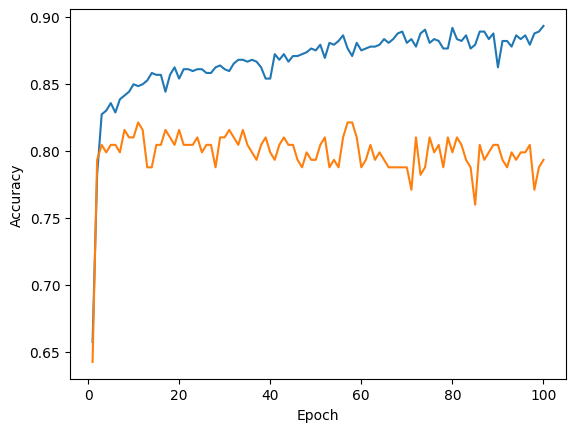

In [37]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.01)

train_model(nn_model, train_loader, test_loader, sdg_opt)

#### Weight Decay = 0.1

Epoch: 1
Loss: 0.6434 | Train Accuracy: 0.7584 | Test Accuracy: 0.7486

Epoch: 2
Loss: 0.5498 | Train Accuracy: 0.7879 | Test Accuracy: 0.8156

Epoch: 3
Loss: 0.6512 | Train Accuracy: 0.7963 | Test Accuracy: 0.8101

Epoch: 4
Loss: 0.5502 | Train Accuracy: 0.8160 | Test Accuracy: 0.8045

Epoch: 5
Loss: 0.4242 | Train Accuracy: 0.8413 | Test Accuracy: 0.8156

Epoch: 6
Loss: 0.5670 | Train Accuracy: 0.8343 | Test Accuracy: 0.8380

Epoch: 7
Loss: 0.8712 | Train Accuracy: 0.8497 | Test Accuracy: 0.8268

Epoch: 8
Loss: 0.4740 | Train Accuracy: 0.8469 | Test Accuracy: 0.8212

Epoch: 9
Loss: 0.3498 | Train Accuracy: 0.8539 | Test Accuracy: 0.8212

Epoch: 10
Loss: 0.6232 | Train Accuracy: 0.8483 | Test Accuracy: 0.8268

Epoch: 11
Loss: 0.8949 | Train Accuracy: 0.8315 | Test Accuracy: 0.8101

Epoch: 12
Loss: 0.4563 | Train Accuracy: 0.8455 | Test Accuracy: 0.8156

Epoch: 13
Loss: 0.6444 | Train Accuracy: 0.8497 | Test Accuracy: 0.8212

Epoch: 14
Loss: 0.7903 | Train Accuracy: 0.8413 | Test Accur

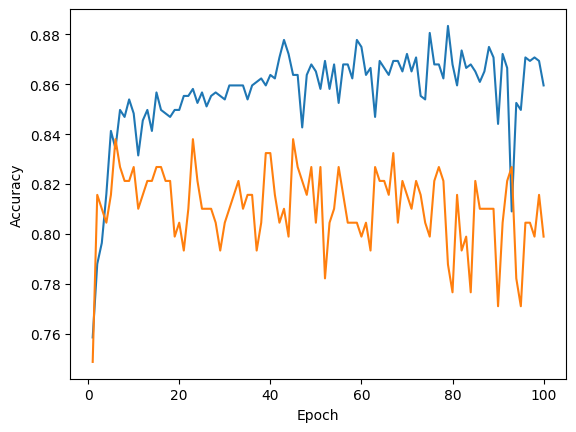

In [38]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.1)

train_model(nn_model, train_loader, test_loader, sdg_opt)

#### Weight Decay = 1

Epoch: 1
Loss: 0.6685 | Train Accuracy: 0.6222 | Test Accuracy: 0.6257

Epoch: 2
Loss: 0.4444 | Train Accuracy: 0.6629 | Test Accuracy: 0.6536

Epoch: 3
Loss: 0.4526 | Train Accuracy: 0.7219 | Test Accuracy: 0.7430

Epoch: 4
Loss: 0.5281 | Train Accuracy: 0.7514 | Test Accuracy: 0.7709

Epoch: 5
Loss: 0.4163 | Train Accuracy: 0.7781 | Test Accuracy: 0.8045

Epoch: 6
Loss: 0.4838 | Train Accuracy: 0.7865 | Test Accuracy: 0.8101

Epoch: 7
Loss: 0.5479 | Train Accuracy: 0.7978 | Test Accuracy: 0.8156

Epoch: 8
Loss: 0.5025 | Train Accuracy: 0.8034 | Test Accuracy: 0.8212

Epoch: 9
Loss: 0.5831 | Train Accuracy: 0.7992 | Test Accuracy: 0.8156

Epoch: 10
Loss: 0.5540 | Train Accuracy: 0.8034 | Test Accuracy: 0.8156

Epoch: 11
Loss: 0.5960 | Train Accuracy: 0.7992 | Test Accuracy: 0.8212

Epoch: 12
Loss: 0.5548 | Train Accuracy: 0.8104 | Test Accuracy: 0.8268

Epoch: 13
Loss: 0.5712 | Train Accuracy: 0.8146 | Test Accuracy: 0.8268

Epoch: 14
Loss: 0.5705 | Train Accuracy: 0.8020 | Test Accur

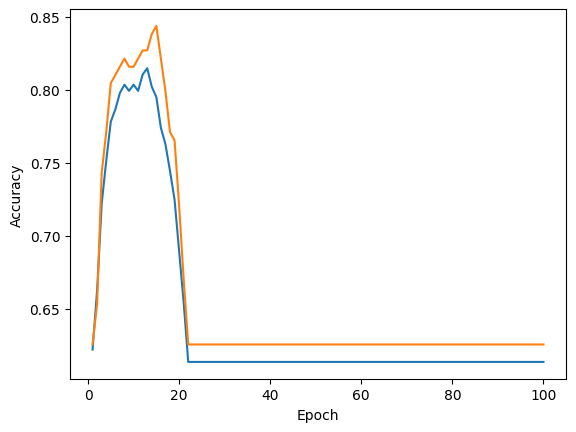

In [39]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1)

train_model(nn_model, train_loader, test_loader, sdg_opt)

### Batch Normalization with Adam Optimizer

Epoch: 1
Loss: 0.2888 | Train Accuracy: 0.8202 | Test Accuracy: 0.8101

Epoch: 2
Loss: 0.2717 | Train Accuracy: 0.7725 | Test Accuracy: 0.7709

Epoch: 3
Loss: 0.3183 | Train Accuracy: 0.8244 | Test Accuracy: 0.7989

Epoch: 4
Loss: 0.1853 | Train Accuracy: 0.8343 | Test Accuracy: 0.7933

Epoch: 5
Loss: 0.3313 | Train Accuracy: 0.8455 | Test Accuracy: 0.7877

Epoch: 6
Loss: 0.2685 | Train Accuracy: 0.8511 | Test Accuracy: 0.7933

Epoch: 7
Loss: 0.2132 | Train Accuracy: 0.8567 | Test Accuracy: 0.8045

Epoch: 8
Loss: 0.3700 | Train Accuracy: 0.8371 | Test Accuracy: 0.8324

Epoch: 9
Loss: 0.5290 | Train Accuracy: 0.8329 | Test Accuracy: 0.8101

Epoch: 10
Loss: 0.2181 | Train Accuracy: 0.8455 | Test Accuracy: 0.8156

Epoch: 11
Loss: 0.3744 | Train Accuracy: 0.8413 | Test Accuracy: 0.8268

Epoch: 12
Loss: 0.2985 | Train Accuracy: 0.8455 | Test Accuracy: 0.8268

Epoch: 13
Loss: 0.6109 | Train Accuracy: 0.8497 | Test Accuracy: 0.8156

Epoch: 14
Loss: 0.1114 | Train Accuracy: 0.8553 | Test Accur

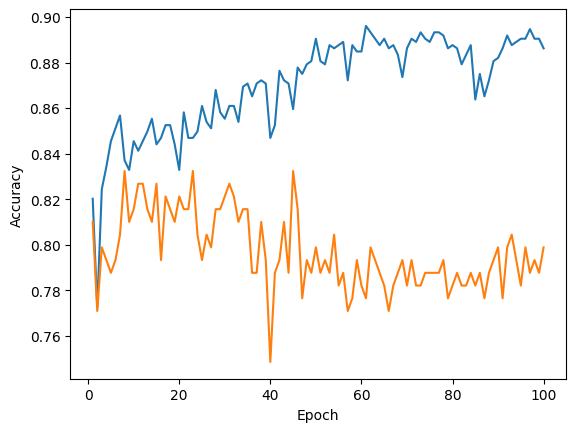

In [40]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

adam_opt = torch.optim.Adam(nn_model.parameters(), lr=1e-2)

train_model(nn_model, train_loader, test_loader, adam_opt)

Batch normalization did not seem to siginificantly affect our model's performance.

## Conclusion

In an attempt to improve our model, we tried different weight decay values, different optimizers, and batch normalization. After testing the various models and comparing it to the original model, we found that there were not significant improvements when implementing these changes.